In [60]:
import numpy as np
import matplotlib.pyplot as plt

Incompressible Navier-Stokes:

$$\begin{align*}
&\nabla \cdot \mathbf{u} = 0,\\
&\frac{\partial \mathbf{u}}{\partial t} = -(\mathbf{u}\cdot\nabla)\mathbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f} .
\end{align*}$$

# Discretization of Fields

The spatial domain will be a rectangular grid split into $N_y$ times $N_x$ cells with each cell centrally associated with a pressure value $(p)_{ij}$.

Each cell will be associated with in-coming and out-going velocities on both x and y axes: 
$$(u_x)_{i,j}, (u_x)_{i,j+1}, (u_y)_{i,j}, (u_y)_{i+1,j}.$$

An exmaple on paper:

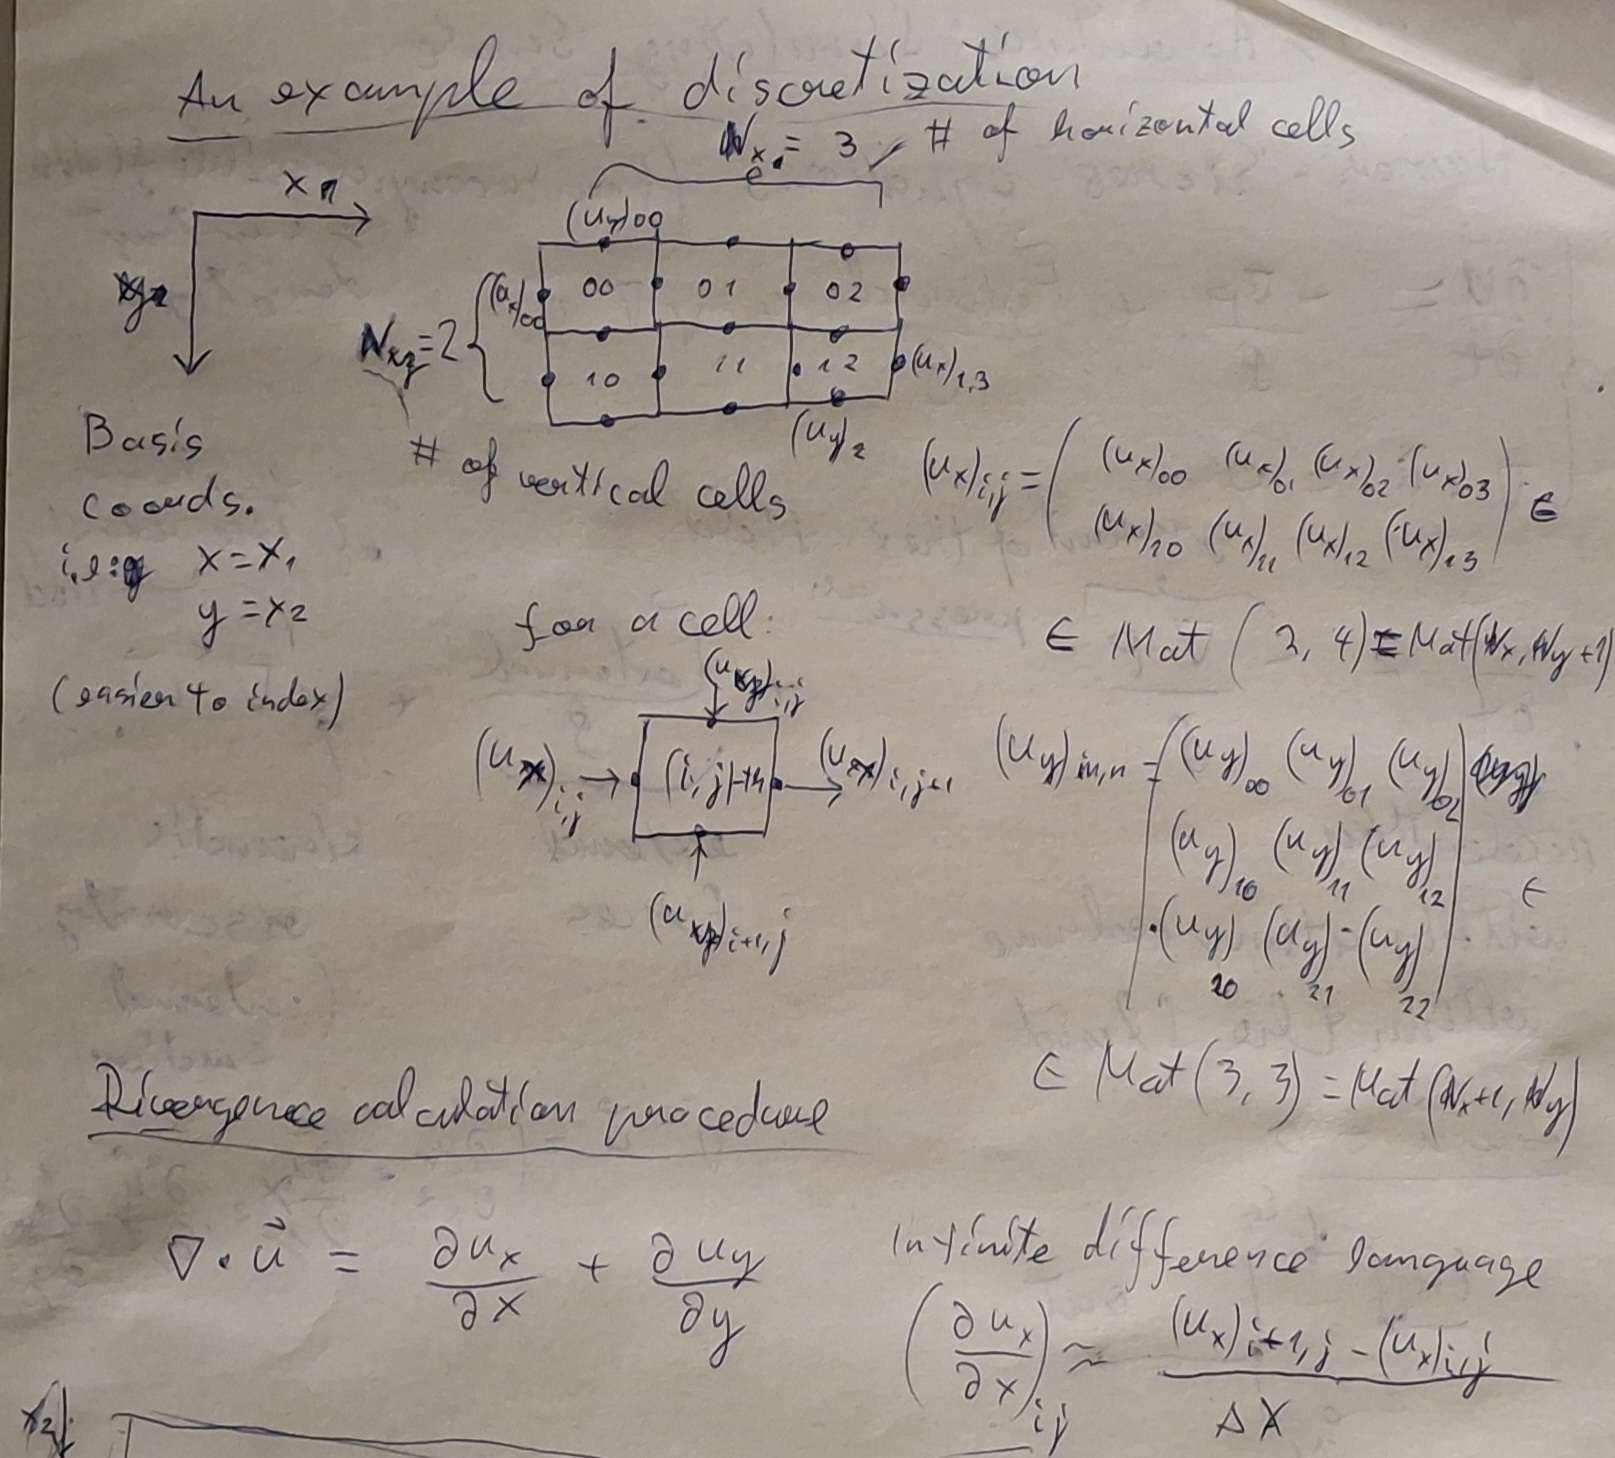

# TODO
## Staggered Grid and Boundary Convention and Index Form Loop for This Prototype

Neumann boundary conditions which act as such that pressure and velocity finite differences near boundaries are 0. That results in the boundaries acting as walls. Boundaries are set to the of the rectangle as well as to the edges of objects (a ball) that are mapped to lie in the center of the domain above source of dye.

Domain consists of $N_y \times N_x$ cells with equal spacings $\Delta x = \Delta y = h$ for both axes and pressure values $(p)_{i,j}$ that are in the center of every $(i,j)$-th cell. The values of $i$ correspond to the y coordinates $y_i = ih$ and j values correspond to x-coordinates $x_i = jh$ that correspond to the coordinates of center cell-s. The cell grid is staggered with respect to the velocity fields horizontal: $(u_x)_{i,j}$, vertical: $(u_y)_{i,j}$ values such that the positive values of $(u_x)_{i,j}, (u_y)_{i,j}$ correspond to the horizontal and vertical in-flow into the $(i,j)$-th cell and velocity field values $(u_x)_{i,j+1}, (u_y)_{i+1,j}$ correspond to the out-flow from the $(i,j)$-th cell through the right edge and bottom edge, respectively.

During the simulation loop, firstly an external force is applied to velocity on each cell's face.

Secondly, semi-Lagrangian advection flow for this type of setup is applied

Thirdly, diffusion of velocities is applied by solving the diffusion equation

$$\frac{\partial \vec{u_2}}{\partial t} = \nu \nabla^2 \vec{u_2}$$

via implicit method that uses bacward differences and result in equation 
$$(I-\nu \Delta t \nabla^2)\vec{u}_3 = \vec{u}_2$$

Finally, the pressure gradient 

$$\frac{\partial \vec{u}_3}{\partial t} = -\frac{\nabla^2 p}{\rho}$$

is applied. Pressure is not known beforehand, but it can be implicitly derived by enforcing the zero-divergence condition
**TODO**

## Gauss-Seidel Iteration Method: An Example

Used to iteratively solve equations of type $A \bf{x} = \bf{b}$.
This iteration method is important in this simulation because it is used in the viscous diffusion and projection step.
 
Example: solve
$$\begin{align*}

&45x_1 + 2x_2 + 3x_3,\\
&-3x_1 + 22x_2 + 2x_3 = 47,\\
&5x_1 + x_2 + 20x_3 = 67\\
\end{align*}$$

with initial guess $$x^{(0)} = [0,0,0]^T$$

In [ ]:
#Gauss-Seidel iteration function written by Perplexity
def gauss_seidel(A, b, x_init=None, tol=1e-6, max_iter=1000):
    """
    Solve the linear system A x = b using Gauss-Seidel iteration.
    
    Parameters:
        A : 2D numpy array (square matrix)
        b : 1D numpy array (right-hand side vector)
        x_init : Initial guess for x (1D numpy array), defaults to zeros
        tol : Tolerance for convergence (stopping criterion)
        max_iter : Maximum number of iterations
    
    Returns:
        x : Solution vector
        iterations : Number of iterations performed
    """
    n = A.shape[0]
    x = np.zeros_like(b) if x_init is None else x_init.copy()
    
    for iteration in range(max_iter):
        x_new = np.copy(x)
        
        for i in range(n):
            s1 = np.dot(A[i, :i], x_new[:i])       # sum over updated x
            s2 = np.dot(A[i, i+1:], x[i+1:])       # sum over old x
            x_new[i] = (b[i] - s1 - s2) / A[i, i]
        
        # Check for convergence
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:
            return x_new, iteration + 1
        
        x = x_new
    
    return x, max_iter

In [19]:
#diagonally dominant matrix
A = np.array([[45,2,3],
              [-3,22,18],
              [5,1,20]])

b = np.array([58,47,67]) 

In [20]:
x_true = np.linalg.solve(A,b)
x_true

array([ 1.09371537, -0.24157037,  3.08864968])

In [22]:
gauss_seidel(A,b, max_iter=3)

(array([1, 0, 3]), 3)

In [3]:
# Fluid grid initialization for velocities, 
class FluidGridInit:
    def __init__(self, cell_count_x, cell_count_y, delta):
        # number of cells in both direction on a rectangular grid
        self.Nx = cell_count_x
        self.Ny = cell_count_y
        self.h = delta # "infinitesimal" value dx = dy = h

        # initialize velocity fields
        self.u_x = np.zeros((self.Ny, self.Nx + 1), dtype=float)
        self.u_y = np.zeros((self.Ny+1, self.Nx), dtype=float)

        # initialize position matrices that coincide with the centers of cells
        x_s = np.linspace(0, (cell_count_x-1), cell_count_x, dtype=np.int32)
        y_s = np.linspace(0, (cell_count_y-1), cell_count_y, dtype=np.int32)

        #index matrices for velocities
        u_x_s = np.arange(0, self.Nx + 1, dtype=np.int32)
        u_y_s = np.arange(0, self.Ny + 1, dtype=np.int32)

        #u_x and u_y indice arrays
        self.u_x_indices_x, self.u_x_indices_y = np.meshgrid(u_x_s, y_s)
        self.u_y_indices_x, self.u_y_indices_y = np.meshgrid(x_s, u_y_s)

        # x-and-y-indices
        self.x_indices, self.y_indices = np.meshgrid(x_s, y_s)
        # x-and-y-coords
        self.x_coords, self.y_coords = np.meshgrid(x_s*delta, y_s*delta)



In [4]:
# discrete "infinitesimal" parameters
h = 0.1 # meters
dt = 0.01 # seconds

N_x = N_y = 100 #
N_x1 = 3
N_y1 = 2

m1_FluidGrid = FluidGridInit(3, 2, h)

u_x1 = m1_FluidGrid.u_x
u_y1 = m1_FluidGrid.u_y

u_x_indices_x1 = m1_FluidGrid.u_x_indices_x
u_x_indices_y1 = m1_FluidGrid.u_x_indices_y

u_y_indices_x1 =  m1_FluidGrid.u_y_indices_x
u_y_indices_y1 =  m1_FluidGrid.u_y_indices_y

x_indices1 = m1_FluidGrid.x_indices
y_indices1 = m1_FluidGrid.y_indices

x_coords1 = m1_FluidGrid.x_coords
y_coords1 = m1_FluidGrid.y_coords


In [5]:
u_x1, u_y1

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]))

In [6]:
u_x_indices_x1, u_x_indices_y1

(array([[0, 1, 2, 3],
        [0, 1, 2, 3]]),
 array([[0, 0, 0, 0],
        [1, 1, 1, 1]]))

In [7]:
u_y_indices_x1, u_y_indices_y1

(array([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]),
 array([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]]))

In [8]:
x_indices1, y_indices1

(array([[0, 1, 2],
        [0, 1, 2]]),
 array([[0, 0, 0],
        [1, 1, 1]]))

In [9]:
x_coords1, y_coords1

(array([[0. , 0.1, 0.2],
        [0. , 0.1, 0.2]]),
 array([[0. , 0. , 0. ],
        [0.1, 0.1, 0.1]]))

# Finite Difference Operators

## Gradient of a scalar field

In [81]:
#this kind of implementation enforces solid edge boundaries
def gradient(P, x_indices, y_indices):
    size_x = len(x_indices[0])
    size_y = len(y_indices.T[0])

    x_clipped = np.clip(x_indices, 1, size_x-2).astype(np.int32)
    y_clipped = np.clip(y_indices, 1, size_y-2).astype(np.int32)

    grad_x = (P[y_clipped, x_clipped+1] - P[y_clipped, x_clipped-1]) / 2
    grad_y = (P[y_clipped+1, x_clipped] - P[y_clipped-1, x_clipped]) / 2
    return grad_x, grad_y

#implementation for periodic boundaries:
def gradientPeriodic(P, x_indices, y_indices):
    """
    Compute central difference gradient with periodic boundaries.
    """
    size_y, size_x = P.shape
    x_idx = x_indices.astype(np.int32)
    y_idx = y_indices.astype(np.int32)

    grad_x = (P[y_idx, (x_idx+1) % size_x] - P[y_idx, (x_idx-1) % size_x]) / 2
    grad_y = (P[(y_idx+1) % size_y, x_idx] - P[(y_idx-1) % size_y, x_idx]) / 2
    return grad_x, grad_y

## Divergence of a vector field

In [ ]:
#divergence implementation for velocities on staggered grid
def divergence(u_x, u_y):
    # du_x/dx: difference along x
    du_x_dx = u_x[:, 1:] - u_x[:, :-1]   # resulting shape: (ny, nx)
    
    # du_y/dy: difference along y
    du_y_dy = u_y[1:, :] - u_y[:-1, :]   # resulting shape: (ny, nx)
    
    return du_x_dx + du_y_dy

In [84]:
u_x_test = np.random.rand(*u_x1.shape)
u_y_test = np.random.rand(*u_y1.shape)

In [85]:
u_x_test, u_y_test

(array([[0.34494688, 0.54488162, 0.9988592 , 0.21599382],
        [0.71700347, 0.02085021, 0.13781871, 0.80595479]]),
 array([[0.94477795, 0.10682245, 0.17469947],
        [0.68435324, 0.79138207, 0.09632418],
        [0.71812975, 0.16255227, 0.69648337]]))

# **TODO**: Update Loop
### 1. Add force

### 2. Advect

### 3. Diffuse

### 4. Project
